# IIC-3670 NLP UC

# PROCESAMIENTO DE LENGUAJE NATURAL

- Versiones de librerías, python 3.8.10

- numpy 1.20.3
- nltk 3.7
- gensim 4.1.2
- keras 2.9.0
- tensorflow 2.9.1


!jupyter notebook --NotebookApp.iopub_data_rate_limit=1e12

In [1]:
import gensim.downloader

print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [2]:
glove_wiki_50 = gensim.downloader.load('glove-wiki-gigaword-50')

In [3]:
glove_wiki_50.most_similar_cosmul(positive=['king', 'woman'], negative=['man'])

[('queen', 0.9288908839225769),
 ('throne', 0.882325291633606),
 ('elizabeth', 0.8789501786231995),
 ('princess', 0.8767548203468323),
 ('daughter', 0.8705160617828369),
 ('prince', 0.8702554702758789),
 ('kingdom', 0.8607221841812134),
 ('eldest', 0.8595449328422546),
 ('monarch', 0.8584721684455872),
 ('widow', 0.8549265265464783)]

In [4]:
glove_wiki_50.similar_by_word('king')

[('prince', 0.8236179351806641),
 ('queen', 0.7839043140411377),
 ('ii', 0.7746230363845825),
 ('emperor', 0.7736247777938843),
 ('son', 0.766719400882721),
 ('uncle', 0.7627150416374207),
 ('kingdom', 0.7542160749435425),
 ('throne', 0.7539913654327393),
 ('brother', 0.7492411136627197),
 ('ruler', 0.7434253692626953)]

In [5]:
glove_wiki_50.doesnt_match(['king', 'george', 'stephen', 'truck'])

'truck'

In [6]:
score, results = glove_wiki_50.evaluate_word_analogies('questions-words.txt')

In [7]:
score

0.463717540798522

In [8]:
import numpy as np

vectors_glove_50 = np.asarray(glove_wiki_50.vectors)
labels_glove_50 = np.asarray(glove_wiki_50.index_to_key)

In [9]:
vectors_glove_50[int(np.where(labels_glove_50 == 'king')[0][0])]

array([ 0.50451 ,  0.68607 , -0.59517 , -0.022801,  0.60046 , -0.13498 ,
       -0.08813 ,  0.47377 , -0.61798 , -0.31012 , -0.076666,  1.493   ,
       -0.034189, -0.98173 ,  0.68229 ,  0.81722 , -0.51874 , -0.31503 ,
       -0.55809 ,  0.66421 ,  0.1961  , -0.13495 , -0.11476 , -0.30344 ,
        0.41177 , -2.223   , -1.0756  , -1.0783  , -0.34354 ,  0.33505 ,
        1.9927  , -0.04234 , -0.64319 ,  0.71125 ,  0.49159 ,  0.16754 ,
        0.34344 , -0.25663 , -0.8523  ,  0.1661  ,  0.40102 ,  1.1685  ,
       -1.0137  , -0.21585 , -0.15155 ,  0.78321 , -0.91241 , -1.6106  ,
       -0.64426 , -0.51042 ], dtype=float32)

In [10]:
import tensorflow
from tensorflow import keras
from sklearn.datasets import fetch_20newsgroups

X_train_text, Y_train = fetch_20newsgroups(subset="train", remove=('headers', 'footers', 'quotes'), return_X_y=True)
X_test_text, Y_test  = fetch_20newsgroups(subset="test", remove=('headers', 'footers', 'quotes'), return_X_y=True)

In [11]:
Y_train

array([7, 4, 4, ..., 3, 1, 8])

In [12]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from nltk.stem import WordNetLemmatizer

classes = np.unique(Y_train)

# Load stop-words
stop_words = set(stopwords.words('english'))

# Initialize tokenizer
# It's also possible to try with a stemmer or to mix a stemmer and a lemmatizer
tokenizer = RegexpTokenizer('[\'a-zA-Z]+')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def tokenize(document):
    words = []

    for sentence in sent_tokenize(document):
        tokens = [lemmatizer.lemmatize(t.lower()) for t in tokenizer.tokenize(sentence) if t.lower() not in stop_words and len(t) > 2]
        words += tokens

    text = ' '.join(words)
    return text

In [13]:
train_docs = []
test_docs = []

for raw_text in X_train_text:
    text = tokenize(raw_text)
    train_docs.append(text)
    
for raw_text in X_test_text:
    text = tokenize(raw_text)
    test_docs.append(text)
    

In [14]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

max_tokens = 50 ## Hyperparameter, input length

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_docs+test_docs)

## Vectorizing data to keep 50 words per sample.
X_train_vect = pad_sequences(tokenizer.texts_to_sequences(train_docs), maxlen=max_tokens, padding="post", truncating="post", value=0.)
X_test_vect  = pad_sequences(tokenizer.texts_to_sequences(test_docs), maxlen=max_tokens, padding="post", truncating="post", value=0.)


X_train_vect.shape, X_test_vect.shape

((11314, 50), (7532, 50))

In [15]:
len(tokenizer.index_word)

95077

Ver configuraciones de Tokenizer en: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

Ver configuraciones de pad_sequences en: https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences

In [16]:
embed_len = 50

glove_50_embeddings = np.zeros((len(tokenizer.index_word)+1, embed_len))

for idx, word in tokenizer.index_word.items():
    if word in labels_glove_50:
        glove_50_embeddings[idx] = vectors_glove_50[int(np.where(labels_glove_50 == word)[0][0])]
    

In [17]:
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Flatten, Input

model = Sequential([
                    Embedding(input_dim=len(tokenizer.index_word)+1, output_dim=embed_len,
                              input_length=max_tokens, trainable=False, weights=[glove_50_embeddings]),
                    Flatten(),
                    Dense(128, activation="relu"),
                    Dense(64, activation="relu"),
                    Dense(20, activation="softmax")
                ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            4753900   
                                                                 
 flatten (Flatten)           (None, 2500)              0         
                                                                 
 dense (Dense)               (None, 128)               320128    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 20)                1300      
                                                                 
Total params: 5,083,584
Trainable params: 329,684
Non-trainable params: 4,753,900
_________________________________________________________________


In [18]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [19]:
model.fit(X_train_vect, Y_train, batch_size=32, epochs=8, validation_data=(X_test_vect, Y_test))

Epoch 1/8
354/354 [==============================] - 2s 5ms/step - loss: 2.0755 - accuracy: 0.3268 - val_loss: 1.8226 - val_accuracy: 0.4068
Epoch 2/8
354/354 [==============================] - 2s 5ms/step - loss: 1.2541 - accuracy: 0.6009 - val_loss: 1.8669 - val_accuracy: 0.4037
Epoch 3/8
354/354 [==============================] - 2s 4ms/step - loss: 0.7991 - accuracy: 0.7563 - val_loss: 2.0641 - val_accuracy: 0.4031
Epoch 4/8
354/354 [==============================] - 2s 5ms/step - loss: 0.4787 - accuracy: 0.8670 - val_loss: 2.3899 - val_accuracy: 0.4020
Epoch 5/8
354/354 [==============================] - 2s 5ms/step - loss: 0.2885 - accuracy: 0.9285 - val_loss: 2.6991 - val_accuracy: 0.3952
Epoch 6/8
354/354 [==============================] - 2s 5ms/step - loss: 0.1973 - accuracy: 0.9542 - val_loss: 2.9690 - val_accuracy: 0.4033
Epoch 7/8
354/354 [==============================] - 2s 5ms/step - loss: 0.1525 - accuracy: 0.9628 - val_loss: 3.2506 - val_accuracy: 0.4027
Epoch 8/8
354

In [20]:
labels = ['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [21]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Y_preds = model.predict(X_test_vect).argmax(axis=-1)

print("Test Accuracy : {}".format(accuracy_score(Y_test, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_test, Y_preds, target_names=labels))

236/236 [==============================] - 1s 2ms/step
Test Accuracy : 0.3948486457780138

Classification Report : 
                          precision    recall  f1-score   support

             alt.atheism       0.26      0.25      0.25       319
           comp.graphics       0.31      0.33      0.32       389
 comp.os.ms-windows.misc       0.34      0.15      0.21       394
comp.sys.ibm.pc.hardware       0.33      0.30      0.32       392
   comp.sys.mac.hardware       0.24      0.31      0.27       385
          comp.windows.x       0.34      0.35      0.34       395
            misc.forsale       0.47      0.47      0.47       390
               rec.autos       0.32      0.46      0.38       396
         rec.motorcycles       0.42      0.35      0.38       398
      rec.sport.baseball       0.49      0.65      0.56       397
        rec.sport.hockey       0.67      0.50      0.58       399
               sci.crypt       0.36      0.38      0.37       396
         sci.electronics 

In [22]:
inputs = Input(shape=(max_tokens, ))
embeddings_layer = Embedding(input_dim=len(tokenizer.index_word)+1, output_dim=embed_len,
                             input_length=max_tokens, trainable=False, weights=[glove_50_embeddings])
dense1 = Dense(128, activation="relu")
dense2 = Dense(64, activation="relu")
dense3 = Dense(len(classes), activation="softmax")

x = embeddings_layer(inputs)
x = tensorflow.reduce_mean(x, axis=1) ### Averaged embeddings of tokens of each example
x = dense1(x)
x = dense2(x)
outputs = dense3(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 50, 50)            4753900   
                                                                 
 tf.math.reduce_mean (TFOpLa  (None, 50)               0         
 mbda)                                                           
                                                                 
 dense_3 (Dense)             (None, 128)               6528      
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 20)                1300      
                                                             

In [23]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [24]:
model.fit(X_train_vect, Y_train, batch_size=32, epochs=8, validation_data=(X_test_vect, Y_test))

Epoch 1/8
354/354 [==============================] - 2s 4ms/step - loss: 2.2647 - accuracy: 0.3039 - val_loss: 1.8772 - val_accuracy: 0.3995
Epoch 2/8
354/354 [==============================] - 1s 4ms/step - loss: 1.7343 - accuracy: 0.4401 - val_loss: 1.7282 - val_accuracy: 0.4634
Epoch 3/8
354/354 [==============================] - 1s 4ms/step - loss: 1.6185 - accuracy: 0.4811 - val_loss: 1.6723 - val_accuracy: 0.4717
Epoch 4/8
354/354 [==============================] - 1s 4ms/step - loss: 1.5578 - accuracy: 0.4972 - val_loss: 1.6426 - val_accuracy: 0.4762
Epoch 5/8
354/354 [==============================] - 1s 4ms/step - loss: 1.5158 - accuracy: 0.5146 - val_loss: 1.6107 - val_accuracy: 0.4924
Epoch 6/8
354/354 [==============================] - 1s 4ms/step - loss: 1.4876 - accuracy: 0.5212 - val_loss: 1.6107 - val_accuracy: 0.4861
Epoch 7/8
354/354 [==============================] - 1s 4ms/step - loss: 1.4571 - accuracy: 0.5317 - val_loss: 1.5979 - val_accuracy: 0.4977
Epoch 8/8
354

In [25]:
Y_preds = model.predict(X_test_vect).argmax(axis=-1)

print("Test Accuracy : {}".format(accuracy_score(Y_test, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_test, Y_preds, target_names=labels))

236/236 [==============================] - 0s 2ms/step
Test Accuracy : 0.49761019649495486

Classification Report : 
                          precision    recall  f1-score   support

             alt.atheism       0.22      0.35      0.27       319
           comp.graphics       0.39      0.56      0.46       389
 comp.os.ms-windows.misc       0.39      0.25      0.30       394
comp.sys.ibm.pc.hardware       0.39      0.42      0.40       392
   comp.sys.mac.hardware       0.34      0.23      0.27       385
          comp.windows.x       0.50      0.41      0.45       395
            misc.forsale       0.57      0.57      0.57       390
               rec.autos       0.62      0.56      0.59       396
         rec.motorcycles       0.34      0.56      0.42       398
      rec.sport.baseball       0.63      0.71      0.67       397
        rec.sport.hockey       0.84      0.72      0.78       399
               sci.crypt       0.53      0.49      0.51       396
         sci.electronics

In [26]:
inputs = Input(shape=(max_tokens, ))
embeddings_layer = Embedding(input_dim=len(tokenizer.index_word)+1, output_dim=embed_len,
                             input_length=max_tokens, trainable=False, weights=[glove_50_embeddings])
dense1 = Dense(128, activation="relu")
dense2 = Dense(64, activation="relu")
dense3 = Dense(len(classes), activation="softmax")

x = embeddings_layer(inputs)
x = tensorflow.reduce_sum(x, axis=1) ### Summed embeddings of tokens of each example
x = dense1(x)
x = dense2(x)
outputs = dense3(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 50, 50)            4753900   
                                                                 
 tf.math.reduce_sum (TFOpLam  (None, 50)               0         
 bda)                                                            
                                                                 
 dense_6 (Dense)             (None, 128)               6528      
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 20)                1300      
                                                           

In [27]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [28]:
model.fit(X_train_vect, Y_train, batch_size=32, epochs=8, validation_data=(X_test_vect, Y_test))

Epoch 1/8
354/354 [==============================] - 2s 4ms/step - loss: 2.3502 - accuracy: 0.3447 - val_loss: 1.8842 - val_accuracy: 0.4206
Epoch 2/8
354/354 [==============================] - 1s 4ms/step - loss: 1.6795 - accuracy: 0.4642 - val_loss: 1.7698 - val_accuracy: 0.4425
Epoch 3/8
354/354 [==============================] - 1s 4ms/step - loss: 1.5689 - accuracy: 0.4956 - val_loss: 1.7146 - val_accuracy: 0.4611
Epoch 4/8
354/354 [==============================] - 1s 4ms/step - loss: 1.4948 - accuracy: 0.5182 - val_loss: 1.7122 - val_accuracy: 0.4661
Epoch 5/8
354/354 [==============================] - 1s 4ms/step - loss: 1.4482 - accuracy: 0.5316 - val_loss: 1.7063 - val_accuracy: 0.4760
Epoch 6/8
354/354 [==============================] - 1s 4ms/step - loss: 1.4013 - accuracy: 0.5460 - val_loss: 1.6827 - val_accuracy: 0.4695
Epoch 7/8
354/354 [==============================] - 1s 4ms/step - loss: 1.3725 - accuracy: 0.5546 - val_loss: 1.6560 - val_accuracy: 0.4813
Epoch 8/8
354

In [29]:
Y_preds = model.predict(X_test_vect).argmax(axis=-1)

print("Test Accuracy : {}".format(accuracy_score(Y_test, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_test, Y_preds, target_names=labels))

236/236 [==============================] - 0s 2ms/step
Test Accuracy : 0.4888475836431227

Classification Report : 
                          precision    recall  f1-score   support

             alt.atheism       0.32      0.28      0.30       319
           comp.graphics       0.39      0.52      0.45       389
 comp.os.ms-windows.misc       0.39      0.27      0.32       394
comp.sys.ibm.pc.hardware       0.37      0.41      0.39       392
   comp.sys.mac.hardware       0.34      0.21      0.26       385
          comp.windows.x       0.43      0.44      0.43       395
            misc.forsale       0.47      0.60      0.53       390
               rec.autos       0.38      0.63      0.47       396
         rec.motorcycles       0.59      0.46      0.52       398
      rec.sport.baseball       0.72      0.51      0.60       397
        rec.sport.hockey       0.63      0.84      0.72       399
               sci.crypt       0.69      0.36      0.47       396
         sci.electronics 

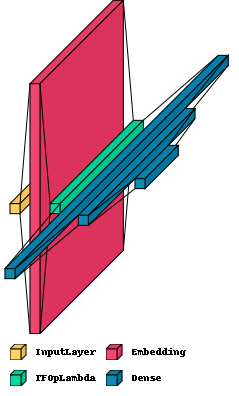

In [53]:
import visualkeras

visualkeras.layered_view(model, legend=True, min_xy=10, min_z=10, scale_xy=5, scale_z=4, one_dim_orientation='x')